## Binary logistic regression

Written by Jess Breda June 2023

In [5]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

Steps
-----
1. generate the dataset
2. Define cost & gradient fx
3. Initialize weights & run optimization
4. Visualize

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# -- PLOT FUNCTIONS -- #
def generate_sigmoids(true_W, optimized_W):
    # create a matrix X with bias column to pass
    # to the sigmoid function
    x_range = np.linspace(-10, 10, 100)
    n_features = len(true_W) - 1
    X_with_bias = np.tile(x_range, (n_features, 1)).T
    X_with_bias = np.c_[np.ones_like(x_range), X_with_bias]  # add bias column

    true_logits = X_with_bias @ true_W
    true_probabilities = sigmoid(true_logits)

    optimized_logits = X_with_bias @ optimized_W
    optimized_probabilities = sigmoid(optimized_logits)

    return x_range, true_probabilities, optimized_probabilities


def plot_sigmoids(x_range, true_probabilities, optimized_probabilities):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(x_range, true_probabilities, label="true", color="gray")
    ax.plot(
        x_range,
        optimized_probabilities,
        label="optimized",
        color="gray",
        linestyle="--",
    )
    ax.legend()
    ax.set(title="Sigmoid Functions", xlabel="Logits", ylabel="Probability")


def plot_weights(true_W, optimized_W):
    fig, ax = plt.subplots(figsize=(6, 4))

    feature_and_bias_labels = np.arange(len(true_W))

    ax.plot(feature_and_bias_labels, true_W, label="true", color="gray", marker="o")
    ax.plot(
        feature_and_bias_labels,
        optimized_W,
        label="optimized",
        color="gray",
        marker="o",
        linestyle="dashed",
    )

    # Set the x-axis tick labels
    _ = ax.set_xticks(feature_and_bias_labels)
    ax.set(xlabel="Feature", ylabel="Weight", title="Recovered Weights")
    ax.legend()

### 1. Generate Data

In [7]:
N = 100000  # Number of samples
D = 2  # Number of features

# Generate random feature values
X = np.random.randn(N, D)  ## convert to Normal

# Generate random true weights (including the bias coefficient)
true_W = np.random.rand(D + 1)

# Add bias column to the dataset
X_with_bias = np.c_[np.ones(N), X]

# Generate target labels using logistic function
logits = X_with_bias @ true_W
probabilities = sigmoid(logits)
y = np.random.binomial(1, probabilities)

### 2. Define cost & gradient functions

These are passed into scipys' `minimize` function. Note `X` includes a first bias column of 1s.

$$ \text{{logits}} = X \cdot W $$

1. Logistic Regression Cost Function:

$$ \text{{nll}} = \frac{1}{n} \sum_{i=1} ^{n}(y \cdot \log(\text{logits}) - \log(1 + \exp(\text{logits})))$$

2. Logistic Regression Gradient Function:

$$p(y) = 1 - \frac{1}{1 + \exp(\text{logits})}$$

$$\nabla \text{nll}_W = \frac{{X^T \cdot (\text{{p(y)}} - y)}}{N}$$


3. Logistic Regression Hessian Function:

$$ \text{Hess} = \frac{1}{n} \sum_{i=1} ^{n} (p(y_i) (1 - p(y_i)) x_i x_i^T )

In [17]:
def logistic_regression_cost(W):
    """Cost function for logistic regression using negative log-likelihood"""
    logits = X_with_bias @ W
    nll = -np.mean(y * logits - np.log(1 + np.exp(logits)))
    return nll


def logistic_regression_gradient(W):
    """Gradient of the cost function for logistic regression using negative log-likelihood"""
    logits = X_with_bias @ W
    probabilities = 1 - 1 / (1 + np.exp(logits))
    gradient = np.dot(X_with_bias.T, (probabilities - y)) / len(y)
    return gradient


def compute_logistic_regression_hessian(X, y, W):
    """Hessian matrix of the cost function for logistic regression using negative log-likelihood."""
    logits = X @ W
    probabilities = 1 - 1 / (1 + np.exp(logits))
    # Outer product for each data point's feature vector and summing them up
    hessian = sum(
        [(prob * (1 - prob) * np.outer(xi, xi)) for xi, prob in zip(X, probabilities)]
    )
    return hessian / len(y)  # Average over all data points

### 3. Initialize Weights & Optimize

L-BFGS-B versus L-BFGS versus BFGS.

**BFGS:** is a quasi-newton method used for optimization that avoids the costly computation of the Hessian. It approximates the inverse Hessian via gradient updates.

**L-BFGS**: is the limited-memory version of BFGS, doesn't store the full Hessian matrix (or inverse), but instead a subset of vectors that represent this matrix

**L-BFGS-B**: is limited memory version + "bounds". You can implemented bound constraints on the variables being optimized to help minimized the search space. If this is implemented without the `bounds` argument, it is the same as L-BFGS.

In [15]:
initial_W = np.zeros(D + 1)  # Initial guess for weights

# optimize using L-BFGS-B algorithm
# NOTE this uses the global variables X_with_bias and y!
result = minimize(
    logistic_regression_cost,
    initial_W,
    method="L-BFGS-B",
    jac=logistic_regression_gradient,
)
optimized_W = result.x

In [10]:
# summarize the result
print("Status : %s" % result["message"])
print("Total Evaluations: %d" % result["nfev"])

print("True weights:", true_W)
print("Optimized weights:", optimized_W)

Status : CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Total Evaluations: 7
True weights: [0.53520623 0.86753383 0.75036129]
Optimized weights: [0.53575848 0.86166043 0.74083912]


### 5. Visualize the results

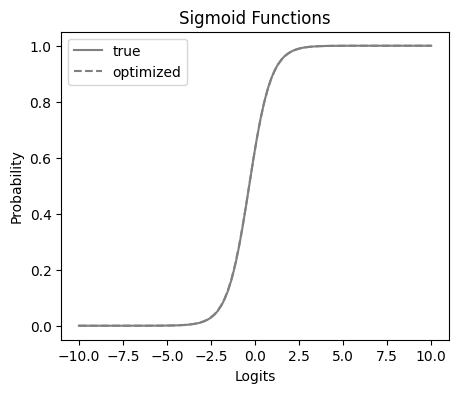

In [11]:
x_range, true_sig, optimized_sig = generate_sigmoids(true_W, optimized_W)
plot_sigmoids(x_range, true_sig, optimized_sig)

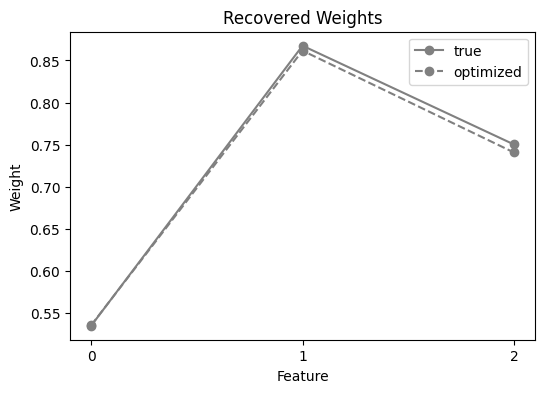

In [12]:
plot_weights(true_W, optimized_W)